In [218]:
import numpy as np
import matplotlib.pyplot as plt

In [219]:
class vertix:
    def __init__(self, id, x, y):
        self.id = id
        self.x = x
        self.y = y

In [220]:
class frame:
    def __init__(self, num_bays, num_floors, bay_length, floor_height, elements_per_bay, elements_per_floor):
        self.num_bays = num_bays
        self.num_floors = num_floors
        self.bay_length = bay_length
        self.floor_height = floor_height
        self.elements_per_bay = elements_per_bay
        self.elements_per_floor = elements_per_floor
        self.basic_count()

    def basic_count(self):
        self.nodes_per_column_line = self.num_floors*self.elements_per_floor + 1
        self.nodes_per_full_bay = self.num_floors*(self.elements_per_bay - 1)

        self.nodes_per_column = self.elements_per_floor - 1
        self.nodes_per_bay = self.elements_per_bay - 1

        self.dx = self.bay_length/self.elements_per_bay
        self.dy = self.floor_height/self.elements_per_floor
        self.num_nodes = self.nodes_per_column_line * (self.num_bays + 1) + self.nodes_per_full_bay*(self.num_bays)
        
    def calculate_vertices(self):
        self.vertices = []
        for column_i in np.arange(0,self.num_bays + 1):
            self.vertices.append([])
            for floor_i in np.arange(0, self.num_floors + 1):
                id = 1 + floor_i*(self.elements_per_floor) + column_i*self.nodes_per_column_line + column_i*self.nodes_per_full_bay
                self.vertices[column_i].append(vertix(id, column_i*self.bay_length, floor_i*self.floor_height))
    
    def calculate_bay_nodes(self):
        self.bay_nodes = []    
        for column_line_i in np.arange(0, self.num_bays):
            starting_vertices = self.vertices[column_line_i]
            self.bay_nodes.append([])
            for vertix_i in np.arange(1, self.num_floors + 1):
                id = (column_line_i + 1)*self.nodes_per_column_line + (column_line_i) *self.nodes_per_full_bay + (vertix_i - 1) * self.nodes_per_bay
                x0 = starting_vertices[vertix_i].x
                y0 = starting_vertices[vertix_i].y
                for node_i in np.arange(1,self.nodes_per_bay + 1):
                    id = id + 1
                    x = x0 + node_i*self.dx
                    y = y0
                    self.bay_nodes[column_line_i].append(vertix(id, x, y))

    def calculate_column_nodes(self):
        self.column_nodes = []
        for column_line_i in np.arange(0, self.num_bays  + 1):
            self.column_nodes.append([])
            for vertix_i in np.arange(0, self.num_floors):
                id = self.vertices[column_line_i][vertix_i].id
                x0 = self.vertices[column_line_i][vertix_i].x
                y0 = self.vertices[column_line_i][vertix_i].y
                for node_i in np.arange(1,self.nodes_per_column + 1):
                    id = id + 1
                    x = x0 
                    y = y0 + node_i*self.dy
                    self.column_nodes[column_line_i].append(vertix(id, x, y))
                
    def find_bay_nodes(self, bay, floor):
        
        bay_nodes = []

        starting_node = 1 + floor*(self.nodes_per_column + 1) + (bay - 1)*self.nodes_per_column_line + (bay - 1)*self.nodes_per_full_bay
        ending_node = starting_node + self.nodes_per_column_line + self.nodes_per_full_bay
        bay_nodes.append(starting_node)
        
        starting_bay_node = bay*self.nodes_per_column_line + (bay - 1)*self.nodes_per_full_bay + (floor - 1)*self.nodes_per_bay 
        for node_i in np.arange(1, self.nodes_per_bay + 1):    
            bay_nodes.append(starting_bay_node + node_i)
        bay_nodes.append(ending_node)
        return bay_nodes


    def plot_vertices(self):
        for column_line in self.vertices:
            for vertix in column_line:
                plt.scatter(vertix.x, vertix.y, c="r")
                plt.text(vertix.x + self.bay_length*0.1, vertix.y - self.floor_height*0.2, f"{vertix.id}", c="r")
    
    def plot_bay_nodes(self):
        for column_line in self.bay_nodes:
            for vertix in column_line:
                plt.scatter(vertix.x, vertix.y, c="b")
                plt.text(vertix.x, vertix.y + self.floor_height*0.1, f"{vertix.id}", c="b")

    def plot_column_nodes(self):
        for column_line in self.column_nodes:
            for vertix in column_line:
                plt.scatter(vertix.x, vertix.y, c="g")
                plt.text(vertix.x - self.bay_length*0.15, vertix.y, f"{vertix.id}", c="g")



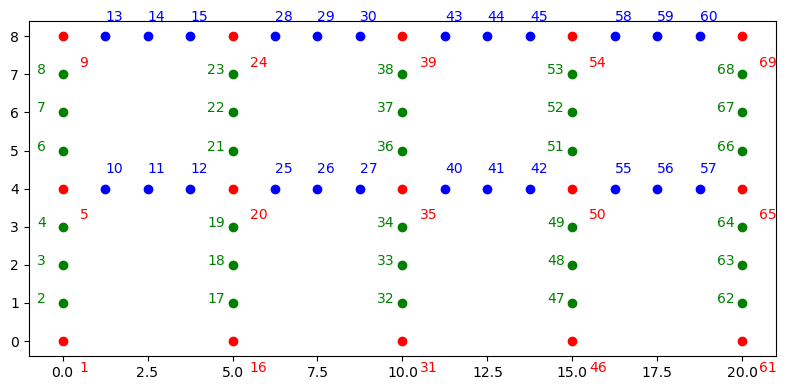

In [229]:
n_bays = 4
n_floors = 2
a_frame = frame(num_bays = n_bays, num_floors = n_floors, 
                bay_length = 5, floor_height = 4, 
                elements_per_bay = 4, elements_per_floor = 4)
a_frame.calculate_vertices()
a_frame.calculate_bay_nodes()
a_frame.calculate_column_nodes()
a_frame.plot_vertices()
a_frame.plot_bay_nodes()
a_frame.plot_column_nodes()
plt.gcf().set_size_inches(n_bays*2, n_floors*2)
plt.tight_layout()

In [230]:
a_frame.find_bay_nodes(2, 1)

[20, 25, 26, 27, 35]

In [222]:
bay = 1
floor = 2
nodes_per_column = a_frame.nodes_per_column
nodes_per_column_line = a_frame.nodes_per_column_line
nodes_per_full_bay = a_frame.nodes_per_full_bay
starting_node = 1 + floor*(nodes_per_column + 1) + (bay - 1)*nodes_per_column_line + (bay - 1)*nodes_per_full_bay

starting_node + nodes_per_column_line + nodes_per_full_bay

26